In [1]:
# %config Completer.use_jedi = False

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive/


In [3]:
!pip3 install Box2D
!pip3 install box2d-py
# !pip3 uninstall gym[all]
!pip3 install gym[Box_2D]

     |████████████████████████████████| 1.3 MB 9.9 MB/s 
     |████████████████████████████████| 448 kB 7.2 MB/s 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple
import random
import gym

In [5]:
env=gym.make('LunarLander-v2')
state=env.reset()

In [6]:
class Buffer():
    def __init__(self, batch_size=128,buffer_size=5e4):
        self.batch_size=batch_size
        self.buffer=buffer_size
        self.relay=[]
        self.timestep=namedtuple('experience',field_names=('state','action','reward','next_state','done'))
        self.count=0
    
    def append_timestep(self,state,action, reward,next_state,done):
        tp=self.timestep(state,action, reward,next_state,done)
        if self.count<self.buffer:
            self.relay.append(tp)
        else:
            self.relay[int((self.count+1)%self.buffer)]=tp
        self.count+=1
            
    def get_samples(self):
        np.random.seed(42)
        samples=random.sample(self.relay,self.batch_size)
        states=torch.from_numpy(np.vstack([e.state for e in samples])).float().cuda()
        actions=torch.from_numpy(np.vstack([e.action for e in samples])).long().cuda()
        rewards=torch.from_numpy(np.vstack([e.reward for e in samples])).float().cuda()
        next_states=torch.from_numpy(np.vstack([e.next_state for e in samples])).float().cuda()
        dones=torch.from_numpy(np.vstack([e.done for e in samples]).astype(np.uint8)).long().cuda()
        return states,actions, rewards,next_states,dones

In [11]:
buffer_test=Buffer()
for i in range(200):
      action=env.action_space.sample()
      next_state, reward, done, info=env.step(action)
      buffer_test.append_timestep(state,action, reward,next_state,done)
      next_state=state
print(len(buffer_test.relay))


200


In [13]:
del buffer_test

In [15]:
print('Shape of state',states.shape)
print('Shape of actions',action.shape)
print('Shape of rewards',rewards.shape)
print('Shape of next_state',next_states.shape)
print('Shape of dones',dones.shape)

Shape of state torch.Size([128, 8])
Shape of actions torch.Size([128, 1])
Shape of rewards torch.Size([128, 1])
Shape of next_state torch.Size([128, 8])
Shape of dones torch.Size([128, 1])


In [16]:
class DDQN(nn.Module):
    def __init__(self, input_size, hidden_layer1=800, hidden_layer2=200,out=4):
        super().__init__()
        self.lin1=nn.Linear(input_size,hidden_layer1)
        self.lin2=nn.Linear(hidden_layer1,hidden_layer2)
        self.lin3=nn.Linear(hidden_layer2,out)
        
        
    def forward(self,X):
        X=F.relu(self.lin1(X))
        X=F.relu(self.lin2(X))
        X=self.lin3(X)
        return X

In [17]:
states.shape

torch.Size([128, 8])

In [18]:
torch.random.manual_seed(42)
pred_DDQN=DDQN(input_size=states.shape[1]).cuda()
target_DDQN=DDQN(input_size=states.shape[1]).cuda()
optimizer=torch.optim.Adam(pred_DDQN.parameters(),lr=5e-4)
criterion=nn.MSELoss()

In [19]:
y_check=pred_DDQN.forward(states)
x=pred_DDQN(states)
# print(x.shape)
# indices=torch.tensor(np.arange(0,64)).long()
# print(indices.shape)
# x.gather(0,indices.reshape(-1,1)).shape

In [20]:
class Agent():
    def __init__(self, buffer, pred_net, tgt_net,seed,reset,gamma=0.99, epsilon=1.0, decay=0.995,epsilon_min=0.01):
        self.pred_net=pred_net
        self.tgt_net=tgt_net
        self.gamma=gamma
        self.epsilon=epsilon
        self.decay=decay
        self.epsilon_min=epsilon_min
        self.seed=seed
        self.count=0
        self.reset=reset
        self.buffer=buffer
        
    def reset_epsilon(self):
        self.epsilon=min(self.epsilon*self.decay,self.epsilon_min)
    def get_action(self,env,state):
        if random.random()>self.epsilon:
            with torch.no_grad():
                state=torch.Tensor(state).float().cuda()
                action=torch.argmax(self.pred_net.forward(state)).item()
        else:
            action = env.action_space.sample()
        return action
    
    def learn_agent(self):
        states,actions, rewards,next_states,dones=self.buffer.get_samples()
        check=self.pred_net(states)
        y_pred=self.pred_net.forward(states).gather(1,actions)
        pred_action=torch.argmax(self.pred_net(next_states),dim=1)
        y_tgt=rewards+self.gamma*((self.tgt_net(next_states).gather(1,pred_action.reshape(-1,1)))*(1-dones).detach())
        loss=criterion(y_pred,y_tgt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        self.count+=1
        return loss
        
    def refresh(self):
        if self.count==self.reset:
            for pred, targ in zip(self.pred_net.parameters(), self.tgt_net.parameters()):
              targ.data.copy_(pred.data)
            self.count=0

In [21]:
buffer=Buffer()
agent=Agent(buffer,pred_DDQN,target_DDQN,42,reset=500)

In [22]:
for i in range(5):
    state=env.reset()
    done=False
    while not done:
        action=env.action_space.sample()
        next_state, reward, done,_ = env.step(action)
        agent.buffer.append_timestep(state,action, reward,next_state,done)
        state=next_state
print(len(agent.buffer.relay))

450


In [23]:
def run_experiment(env, agent, episode_count):
    losses_episode=[]
    rewards_episode=[]
    best_avg_reward=-np.inf
    for i in range(episode_count):
        reward_episode=0
        print('\rEpisode {} '.format(i),end="")
        state=env.reset()
        done=False
        while not done:
            action=agent.get_action(env,state)
            next_state,reward,done,_=env.step(action)
            reward_episode+=reward
            agent.buffer.append_timestep(state,action, reward,next_state,done)
            loss=agent.learn_agent()
            state=next_state
            agent.refresh()
        if (i+1)%100==0:
            avg_reward=np.mean(rewards_episode[-100:])
            print('\nAverage Reward for last 100 episodes:',avg_reward)
            print(f'Loss for {i}th episode is:',loss.item())
            print('\n')
            if avg_reward>200:
                print(f'Threshold average crossed. Average reward:',avg_reward)
                print('\n')
                torch.save(agent.pred_net.state_dict(), 'DDQN_large_pred_model_weights.pth')
                torch.save(agent.tgt_net.state_dict(), 'DDQN_large_target_model_weights.pth')
            if avg_reward > best_avg_reward:
                best_avg_reward=avg_reward
                if avg_reward>200:
                    print('\nPrevious average beaten. New average reward:', best_avg_reward)
                    print('\n')
                    torch.save(agent.pred_net.state_dict(), 'DDQN_large_pred_best_model_weights.pth')
                    torch.save(agent.tgt_net.state_dict(), 'DDQN_large_target_best_model_weights.pth')
        agent.reset_epsilon()
        losses_episode.append(loss.item())
        rewards_episode.append(reward_episode)
    return losses_episode, rewards_episode

In [24]:
final_losses,final_rewards=run_experiment(env, agent, episode_count=2000)

Episode 99 
Average Reward for last 100 episodes: -38.84886167153311
Loss for 99th episode is: 2.7154483795166016


Episode 199 
Average Reward for last 100 episodes: 98.72284861075642
Loss for 199th episode is: 14.955883026123047


Episode 299 
Average Reward for last 100 episodes: 214.59441636141074
Loss for 299th episode is: 2.0377445220947266


Threshold average crossed. Average reward: 214.59441636141074



Previous average beaten. New average reward: 214.59441636141074


Episode 399 
Average Reward for last 100 episodes: 251.05020513174728
Loss for 399th episode is: 1.4028091430664062


Threshold average crossed. Average reward: 251.05020513174728



Previous average beaten. New average reward: 251.05020513174728


Episode 499 
Average Reward for last 100 episodes: 258.9997042139893
Loss for 499th episode is: 4.0362467765808105


Threshold average crossed. Average reward: 258.9997042139893



Previous average beaten. New average reward: 258.9997042139893


Episode 599 
Average Re

In [25]:
np.save('DDQN_large_epside_rewards_large.txt',final_rewards)
np.save('DDQN_large_episode_loss_large.txt',final_losses)

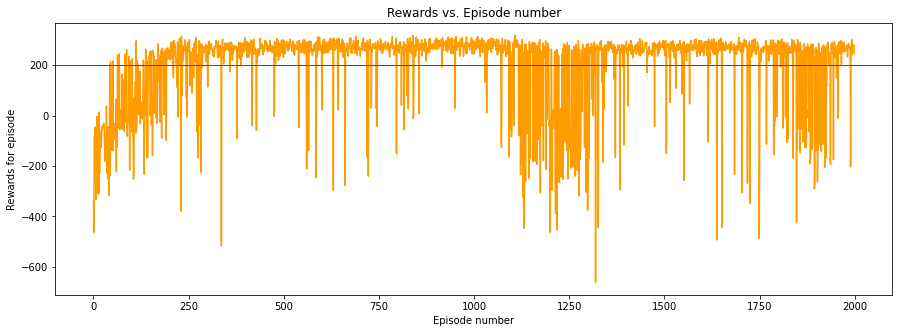

In [26]:
plt.figure(figsize=(15,5))
plt.plot(range(2000),final_rewards,color='#ff9c00')
plt.axhline(y=200,linewidth=1,color='red')
plt.xlabel('Episode number')
plt.ylabel('Rewards for episode')
plt.title('Rewards vs. Episode number')
plt.show()

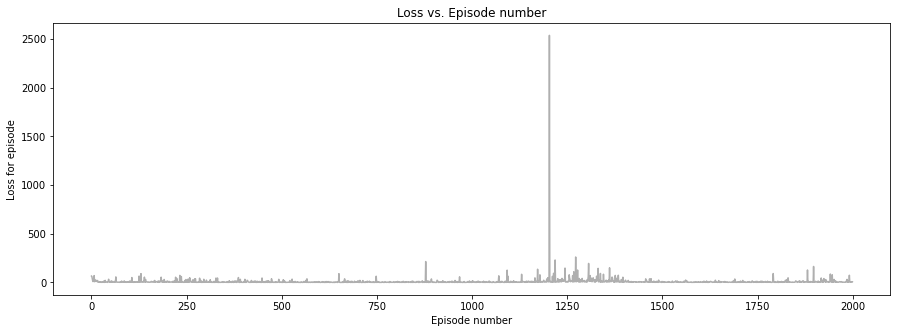

In [27]:
plt.figure(figsize=(15,5))
plt.plot(range(2000),final_losses,color='#afafaf')
plt.xlabel('Episode number')
plt.ylabel('Loss for episode')
plt.title('Loss vs. Episode number')
plt.show()

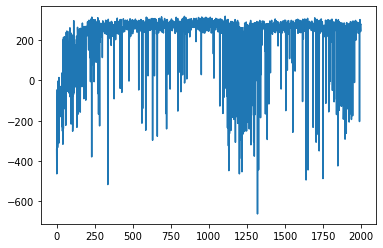

In [28]:
plt.plot(range(2000), final_rewards)